In [1]:
from tqdm import tqdm
from locscale.include.emmer.pdb.pdb_utils import get_coordinates
import os 
import numpy as np

parent_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations"
atomic_model_path = os.path.join(parent_folder, "PDB_5vkq_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb")
atomic_positions = get_coordinates(atomic_model_path)

ignore_model_path = os.path.join(parent_folder, "cropped_model_pdb_5vkq.pdb")
ignore_positions = get_coordinates(ignore_model_path)

atomic_positions_array = np.array(atomic_positions)
ignore_positions_array = np.array(ignore_positions)

atomic_positions_to_test = np.array([position for position in atomic_positions_array if position not in ignore_positions_array])

pseudomodels_folder = os.path.join(parent_folder, "pseudomodels")
pseudomodels_paths = [os.path.join(pseudomodels_folder, i) for i in os.listdir(pseudomodels_folder) if i.endswith(".mmcif")]
pseudomodel_positions = [np.array(get_coordinates(pseudomodel_path)) for pseudomodel_path in pseudomodels_paths]

In [12]:
import gemmi
st_full = gemmi.Structure()
for pseudomodel_path in tqdm(pseudomodels_paths):
    st = gemmi.read_structure(pseudomodel_path)
    st_full.add_model(st[0])

st_full.write_pdb(os.path.join(parent_folder, "pseudomodels", "pseudomodels_combined.pdb"))

100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


In [2]:
from sklearn.neighbors import KDTree

def get_reference_position(target_position_array, reference_positions_array, max_distance=5):
    reference_position_tree = KDTree(reference_positions_array)
    matching_dictionary = {}
    for position in target_position_array:
        indices = reference_position_tree.query_radius(position.reshape(1, -1), r=max_distance)
        if len(indices[0]) > 0:
            ref_position_for_this_target_position = reference_positions_array[indices[0][0]]
            matching_dictionary[tuple(position)] = ref_position_for_this_target_position
    return matching_dictionary

ref_positions = get_reference_position(pseudomodel_positions[-1], atomic_positions_to_test)
    
    

In [3]:
import random 
sample_key = random.choice(list(ref_positions.keys()))
print(sample_key, ref_positions[sample_key], "distance = ", np.linalg.norm(sample_key - ref_positions[sample_key]))

(212.931227, 204.164986, 214.536549) [211.522 202.452 210.37 ] distance =  4.7202089300290595


In [4]:
match_pseudoatom_position_to_atomic_position = {}
for i, pseudoatom_position in enumerate(pseudomodel_positions[-1]):
    atomic_index = i 
    if tuple(pseudoatom_position) in ref_positions:
        match_pseudoatom_position_to_atomic_position[atomic_index] = ref_positions[tuple(pseudoatom_position)]
    else:
        match_pseudoatom_position_to_atomic_position[atomic_index] = None


In [5]:
atom_trajectory_positions = []
num_atoms = len(pseudomodel_positions[0])
for atom_index in tqdm(range(num_atoms)):
    positions_for_each_iteration = [] 
    for iteration_index in range(len(pseudomodel_positions)):
        positions_for_each_iteration.append(pseudomodel_positions[iteration_index][atom_index])
    atom_trajectory_positions.append(positions_for_each_iteration)

100%|██████████| 48205/48205 [00:02<00:00, 23074.31it/s]


In [6]:
# find how close each atom is to the reference position during each iteration
distance_to_reference = []
for atom_index in tqdm(range(num_atoms)):
    if match_pseudoatom_position_to_atomic_position[atom_index] is not None:
        distances_for_each_iteration = []
        for iteration_index in range(len(pseudomodel_positions)):        
            distances_for_each_iteration.append(np.linalg.norm(atom_trajectory_positions[atom_index][iteration_index] - match_pseudoatom_position_to_atomic_position[atom_index]))
        distance_to_reference.append(distances_for_each_iteration)

100%|██████████| 48205/48205 [00:13<00:00, 3530.43it/s]


In [7]:
# find out how much the atom moves during each iteration relative to the first iteration
movement_relative_to_first_iteration = []
for atom_index in tqdm(range(num_atoms)):
    movement_for_each_iteration = []
    for iteration_index in range(len(pseudomodel_positions)):
        movement_for_each_iteration.append(np.linalg.norm(atom_trajectory_positions[atom_index][iteration_index] - atom_trajectory_positions[atom_index][0]))
    movement_relative_to_first_iteration.append(movement_for_each_iteration)

100%|██████████| 48205/48205 [00:32<00:00, 1462.84it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 1036.08it/s]


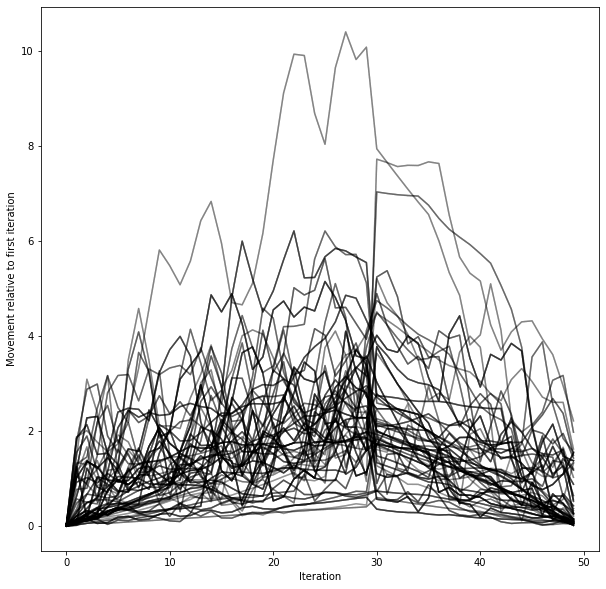

In [11]:
import matplotlib.pyplot as plt
sample_atom_indices = np.random.choice(range(len(movement_for_each_iteration)), 500)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for atom_index in tqdm(sample_atom_indices):
    movement_atom = movement_relative_to_first_iteration[atom_index]
    ax.plot(movement_atom, color="black", alpha=0.1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Movement relative to first iteration")
plt.show()
    

In [6]:
velocities_per_atom = []
for atom_trajectory in tqdm(atom_trajectory_positions):
    atom_trajectory = np.array(atom_trajectory)
    velocities = np.diff(atom_trajectory, axis=0)
    velocities_magnitude = np.linalg.norm(velocities, axis=1)
    velocities_per_atom.append(velocities_magnitude)
    

100%|██████████| 48205/48205 [00:02<00:00, 18050.81it/s]


In [16]:
accelerations_per_atom = []
for atom_trajectory in tqdm(atom_trajectory_positions):
    atom_trajectory = np.array(atom_trajectory)
    velocities = np.diff(atom_trajectory, axis=0)
    accelerations = np.diff(velocities, axis=0)
    accelerations_magnitude = np.linalg.norm(accelerations, axis=1)
    accelerations_per_atom.append(accelerations_magnitude)
    

100%|██████████| 48205/48205 [00:04<00:00, 10597.42it/s]


IndexError: list index out of range

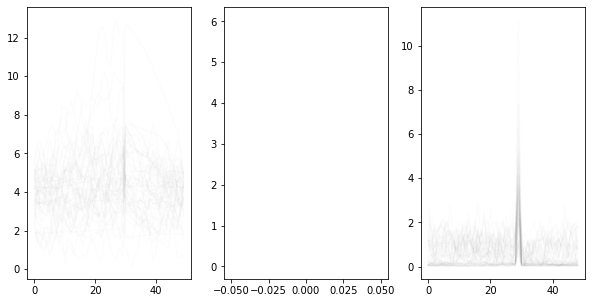

In [63]:
sample_atom_indices = np.random.choice(range(len(movement_for_each_iteration)), 500)
sample_atom_velocities = [velocities_per_atom[i] for i in sample_atom_indices]
sample_atom_accelerations = [accelerations_per_atom[i] for i in sample_atom_indices]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i in range(len(sample_atom_velocities)):
    ax[0].plot(distance_to_reference[i], alpha=0.01, color="black")
    ax[1].plot(movement_for_each_iteration[i], alpha=0.01, color="black")
    ax[2].plot(sample_atom_velocities[i], alpha=0.01, color="black")

ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Distance to reference (Angstroms)")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Movement (Angstroms)")
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Velocity (Angstroms / iteration)")
plt.show()